# Variational Autoencoder mini-Project Pytorch

**keywords:** Pytorch, rdkit, SMILES, Variational Autoencoder, 1D CNN, GRU

The dataset consist of SMILES (Simplified molecular-input line-entry system). The goal is to reconstruct the SMILES and then try to generate new SMILES with the  properties  

This notebook is a toy example based on the paper  [Automatic Chemical Design Using a Data-Driven Continuous Representation of Molecules](https://pubs.acs.org/doi/10.1021/acscentsci.7b00572) and the impementation of [molecular-vae / github repo by Akshay Subramanian](https://github.com/aksub99/molecular-vae).

**Note:** The purpose of this notebook is to apply a Variational Autoencoder with pytorch, I am not a chemisist thus I cannot interpret the outcome of the network properly. 



In [1]:
# Reference: https://gist.github.com/philopon/a75a33919d9ae41dbed5bc6a39f5ede2
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO

logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)

def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))

if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.03.3 installation finished!


In [2]:
# Imports
import sys
import os
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In this notebook, the file with SMILES containing 8 atoms from the GDB-11 dataset will be used. It contains all molecules possible to generate with a subset of atoms and bond types. The dataset can be downloaded here: http://gdb.unibe.ch/downloads/.

The preprocessing to one hot encoding is from [cheminformania.com](http://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/) [1] by  Esben Jannik Bjerrum.





In [3]:
# download the data
!wget http://gdbtools.unibe.ch:8080/cdn/gdb11.tgz

# unzip the data
!tar -xvzf gdb11.tgz

--2020-08-02 12:50:44--  http://gdbtools.unibe.ch:8080/cdn/gdb11.tgz
Resolving gdbtools.unibe.ch (gdbtools.unibe.ch)... 130.92.106.211
Connecting to gdbtools.unibe.ch (gdbtools.unibe.ch)|130.92.106.211|:8080... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122040261 (116M)
Saving to: ‘gdb11.tgz’

gdb11.tgz           100%[===================>] 116.39M  55.7MB/s    in 2.1s    

2020-08-02 12:50:47 (55.7 MB/s) - ‘gdb11.tgz’ saved [122040261/122040261]

gdb11_size01.smi
gdb11_size02.smi
gdb11_size03.smi
gdb11_size04.smi
gdb11_size05.smi
gdb11_size06.smi
gdb11_size07.smi
gdb11_size08.smi
gdb11_size09.smi
gdb11_size10.smi
gdb11_size11.smi


In [4]:
import random
random.seed(1)

In [5]:
smifile = "gdb11_size08.smi"

data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","No","Int"])
from sklearn.model_selection import train_test_split
smiles_train, smiles_valid = train_test_split(data["smiles"], random_state=42)
print("Training examples:", smiles_train.shape[0])
print("Validation examples:", smiles_valid.shape[0])

Training examples: 50029
Validation examples: 16677


The SMILE examples look like this:

In [6]:
smiles_train[:8]

43342        N#CC#CC1COC1
4937     CC1(CC1)C(F)(F)F
19273      CCC(=C)C(=C)CF
47569        FC(F)c1cnco1
51804        C=CC1CN=CNO1
22303        ONC(=O)OC=NO
11915      CC(CC=C)=C(F)F
48363      C1CCN2CC(C1)C2
Name: smiles, dtype: object

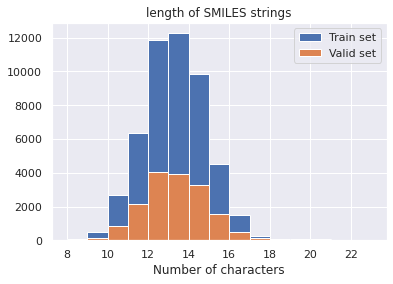

In [7]:
lengths_train = [len(sm) for sm in smiles_train]
lengths_valid = [len(sm) for sm in smiles_valid]

plt.hist(lengths_train, bins=15)
plt.hist(lengths_valid, bins=15)
plt.title('length of SMILES strings')
plt.xlabel('Number of characters')
plt.legend(['Train set','Valid set'])
plt.show();

The train and validation sets have SMILES with the same range of their length.

Let's visualize some of the molecules of training set.

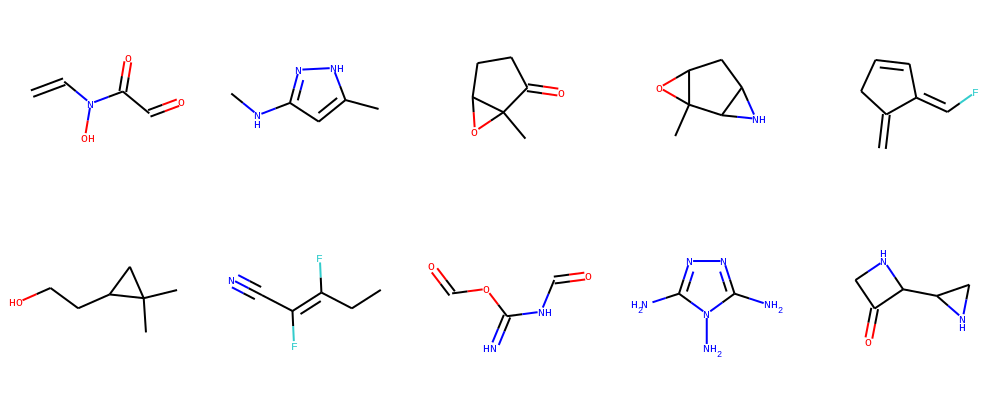

In [8]:
smiles_list = smiles_train[100:110]
mol_list = []
for smile in smiles_list:
  mol = Chem.MolFromSmiles(smile)
  mol_list.append(mol)

img = Chem.Draw.MolsToGridImage(mol_list, molsPerRow=5)
img

Every SMILE string will end with the token E, so we will pad the SMILES to have the same length. This will make the network computationaly more efficient. 

In [9]:
charset = set("".join(list(data.smiles))+"E")  
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 4
print(str(charset))
print("Number of different characters:", len(charset))
print("Max SMILE length:", embed)

{'N', 'C', 'E', '+', ']', '=', '#', '1', 'o', '3', '[', 'H', ')', 'F', '4', '-', '2', '(', 'c', 'n', 'O'}
Number of different characters: 21
Max SMILE length: 27


In [10]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the chars
            for j,c in enumerate(smile):
                one_hot[i,j,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile):,char_to_int["E"]] = 1
        return one_hot[:,0:-1,:]
        
X_train = vectorize(smiles_train.values)
X_valid = vectorize(smiles_valid.values)

In [11]:
print(X_train.shape)
print(X_valid.shape)

(50029, 26, 21)
(16677, 26, 21)


ON(C=C)C(=O)C=O


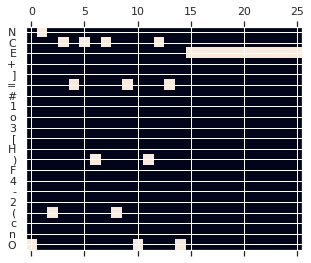

In [12]:
i = 100
print(smiles_train.iloc[i])
plt.matshow(X_train[i].T);
plt.yticks(range(len(charset)),list(charset));

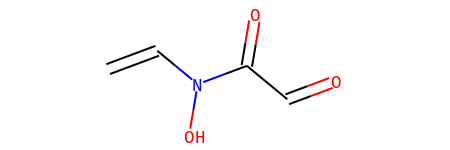

In [13]:
Chem.MolFromSmiles(smiles_train.iloc[i])

Make the torch Data Loaders.

In [14]:
import torch

data_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float())
train_loader = torch.utils.data.DataLoader(data_train, batch_size=250, 
                                           shuffle=True, num_workers=3, 
                                           pin_memory=True)
data_valid = torch.utils.data.TensorDataset(torch.from_numpy(X_valid).float())
valid_loader = torch.utils.data.DataLoader(data_valid, batch_size=250, 
                                          shuffle=False, num_workers=3, 
                                          pin_memory=True)

# Model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [35]:
class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        self.conv_1 = nn.Conv1d(26, 13, kernel_size=9)
        self.conv_2 = nn.Conv1d(13, 9, kernel_size=9)
        self.linear_0 = nn.Linear(45, 435)  
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, 21)  
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    def reparameterize(self, z_mean, z_logvar): 
        epsilon = 1e-2 * torch.randn_like(z_logvar)     # Sample epsilon
        return z_mean + epsilon * torch.exp(z_logvar/2.)  


    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 26, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

In [17]:
def loss_function(x_hat, x, z_mean, z_logvar):
    BCE = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return BCE + KLD

In [18]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MolecularVAE().to(device)

model

MolecularVAE(
  (conv_1): Conv1d(26, 13, kernel_size=(9,), stride=(1,))
  (conv_2): Conv1d(13, 9, kernel_size=(9,), stride=(1,))
  (linear_0): Linear(in_features=45, out_features=435, bias=True)
  (linear_1): Linear(in_features=435, out_features=292, bias=True)
  (linear_2): Linear(in_features=435, out_features=292, bias=True)
  (linear_3): Linear(in_features=292, out_features=292, bias=True)
  (gru): GRU(292, 501, num_layers=3, batch_first=True)
  (linear_4): Linear(in_features=501, out_features=21, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

In [36]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 4,587,758 trainable parameters.


# Train

In [24]:
epochs = 25 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [25]:
# Training and testing the VAE
tr_loss_log = []
val_loss_log = []

codes = dict(μ=list(), logσ2=list())
for epoch in tqdm(range(0, epochs + 1)):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x in train_loader:
            x = x[0].to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        train_loss /= len(train_loader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {train_loss:.5f}')
        tr_loss_log.append(train_loss)
    # Testing
    
    means, logvars = list(), list()
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        for x in valid_loader:
            x = x[0].to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            valid_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    valid_loss /= len(valid_loader.dataset)
    print(f'====> Valid set loss: {valid_loss:.5f}')
    val_loss_log.append(valid_loss)
    inp = np.asarray(x[0].cpu())
    outp = np.asarray(x_hat[0].cpu().detach())
    print("Input-Target:")
    print("".join([int_to_char[idx] for idx in np.argmax(inp, axis=1)]))
    print("Output:")
    print("".join([int_to_char[idx] for idx in np.argmax(outp, axis=1)]))

====> Valid set loss: 105.74420
Input-Target:
COC=CCCCOEEEEEEEEEEEEEEEEE
Output:
OOOOOOOOOOOOOOOOOOOOOOOOOO
====> Epoch: 1 Average loss: 43.17781
====> Valid set loss: 37.38765
Input-Target:
COC=CCCCOEEEEEEEEEEEEEEEEE
Output:
CCCCCCCCCEEEEEEEEEEEEEEEEE
====> Epoch: 2 Average loss: 36.19602
====> Valid set loss: 52.15723
Input-Target:
COC=CCCCOEEEEEEEEEEEEEEEEE
Output:
CCCCCCOEEEEEEEEEEEEEEEEEEE
====> Epoch: 3 Average loss: 33.49772
====> Valid set loss: 30.25048
Input-Target:
COC=CCCCOEEEEEEEEEEEEEEEEE
Output:
CCCCCCCCOEEEEEEEEEEEEEEEEE
====> Epoch: 4 Average loss: 28.72258
====> Valid set loss: 27.07430
Input-Target:
COC=CCCCOEEEEEEEEEEEEEEEEE
Output:
CCCCCCCCCEEEEEEEEEEEEEEEEE
====> Epoch: 5 Average loss: 24.78252
====> Valid set loss: 22.34488
Input-Target:
COC=CCCCOEEEEEEEEEEEEEEEEE
Output:
CCCCCCCCOEEEEEEEEEEEEEEEEE
====> Epoch: 6 Average loss: 21.35486
====> Valid set loss: 21.51260
Input-Target:
COC=CCCCOEEEEEEEEEEEEEEEEE
Output:
CCC=CCCCCEEEEEEEEEEEEEEEEE
====> Epoch: 7 Average

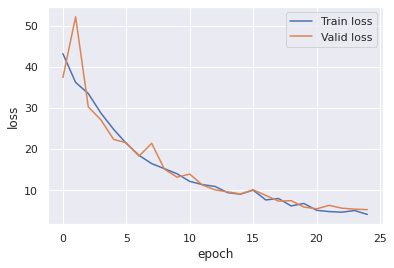

In [26]:
plt.plot(tr_loss_log)
plt.plot(val_loss_log[1:])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss','Valid loss'])
plt.show();

# Generate based on new examples

In [27]:
# Generating a few samples based on specific ones

# get a batch of examples (not from train set)
with torch.no_grad():
    model.eval()
    for x in valid_loader:
        x = x[0].to(device)
        x_hat, mu, logvar = model(x)
        break

z = model.reparameterize(mu, logvar)
z = z[:20,:] #take 20

sample = model.decode(z)

_, smp = torch.max(sample, axis=2)
smp = np.asarray(smp.cpu())

def to_SML_str(smp):
    SML = "".join([int_to_char[idx] for idx in smp])
    for i, char in enumerate(SML):
        if char=="E": 
            break
    return SML[:i]

In [28]:
[to_SML_str(s) for s in smp]

['OCCC1CN=CO1',
 'CCC(F)CC(N)=N',
 'C=C1CCNN=CC1',
 'FC1CCC1CF)C=C',
 'O1C=CC2OC2C=C1',
 'CCCc1ccon1',
 'FC=CC=CC(F)=C',
 'FC(=C)COOC=C',
 'CC(OCC=C)=NN',
 'CC1CCCCCC1',
 'CON(C)C(=N)NN',
 'CC1(CN1)C2CC2O',
 'CC(F)(CF)C1CN1',
 'FC1CC1(CF)C=C',
 'CC(N)=C=CF)C=O',
 'O=CC12CCCC1O2',
 'CCOC(C))=CF',
 'CN=c1nconn1',
 'CNN=CCCC#C',
 'FC1CCC=CCC1']

RDKit ERROR: [13:12:38] SMILES Parse Error: extra close parentheses while parsing: FC1CCC1CF)C=C
RDKit ERROR: [13:12:38] SMILES Parse Error: Failed parsing SMILES 'FC1CCC1CF)C=C' for input: 'FC1CCC1CF)C=C'
RDKit ERROR: [13:12:38] SMILES Parse Error: extra close parentheses while parsing: CC(N)=C=CF)C=O
RDKit ERROR: [13:12:38] SMILES Parse Error: Failed parsing SMILES 'CC(N)=C=CF)C=O' for input: 'CC(N)=C=CF)C=O'
RDKit ERROR: [13:12:38] SMILES Parse Error: extra close parentheses while parsing: CCOC(C))=CF
RDKit ERROR: [13:12:38] SMILES Parse Error: Failed parsing SMILES 'CCOC(C))=CF' for input: 'CCOC(C))=CF'


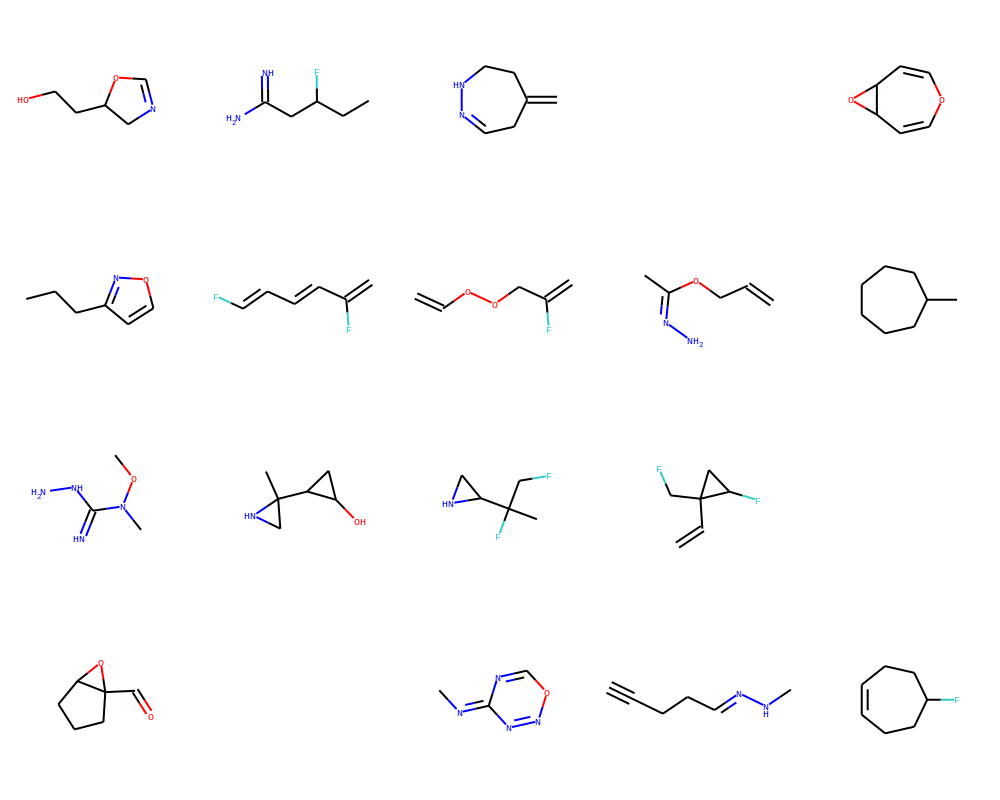

In [29]:
smiles_list = [to_SML_str(s) for s in smp]
mol_list = []
for smile in smiles_list:
  mol = Chem.MolFromSmiles(smile)
  mol_list.append(mol)

img = Chem.Draw.MolsToGridImage(mol_list, molsPerRow=5)
img

We can see that some of the molecules are not proper.

# References:


1.   [Master your molecule generator: Seq2seq RNN models with SMILES in Keras / by Esben Jannik Bjerrum from cheminformania.com](http://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/)
2.   [install rdkit in google colab / github repo by Hirotomo Moriwaki](https://gist.github.com/philopon/a75a33919d9ae41dbed5bc6a39f5ede2)
3.   [Automatic Chemical Design Using a Data-Driven Continuous Representation of Molecules / by
Rafael Gómez-Bombarelli, Jennifer N. Wei, David Duvenaud, José Miguel Hernández-Lobato, Benjamín Sánchez-Lengeling, Dennis Sheberla, Jorge Aguilera-Iparraguirre, Timothy D. Hirzel, Ryan P. Adams, and Alán Aspuru-Guzik
ACS Central Science 2018 4 (2), 268-276
DOI: 10.1021/acscentsci.7b00572](https://pubs.acs.org/doi/10.1021/acscentsci.7b00572)
4.   [molecular-vae / github repo by Akshay Subramanian](https://github.com/aksub99/molecular-vae)
5.   [Pytorch-Deep-Learning github repo by Alfredo Canziani](https://github.com/Atcold/pytorch-Deep-Learning)

